In [30]:
import boto3
import json
import tarfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [31]:
s3_client = boto3.client('s3')

# Replace 'my_bucket' with your S3 bucket name and 'my_key' with the path to your JSON file.
bucket_name = 'my_bucket'
file_key = 'my_key_path/output/output.tar.gz'
s3_object = s3_client.get_object(Bucket=bucket_name, Key=file_key)
content = s3_object['Body'].read()

# Use BytesIO object as a file-like object for tarfile to extract
tar_file_obj = io.BytesIO(content)
with tarfile.open(fileobj=tar_file_obj, mode="r:gz") as tar:
    file_names = tar.getnames()
    for file_name in file_names:
        member = tar.getmember(file_name)
        file_obj = tar.extractfile(member)
        if file_obj:  
            json_content = json.load(file_obj)
            


In [32]:
confusion_matrices = json_content['confusion_matrix']
labels = json_content['labels']

In [33]:
dfs = []
for i, matrix in enumerate(confusion_matrices):
    df = pd.DataFrame(matrix, columns=['Predicted Negative', 'Predicted Positive'],
                      index=['Actual Negative', 'Actual Positive'])
    df['Label'] = labels[i]
    dfs.append(df)

all_dfs = pd.concat(dfs, keys=labels)


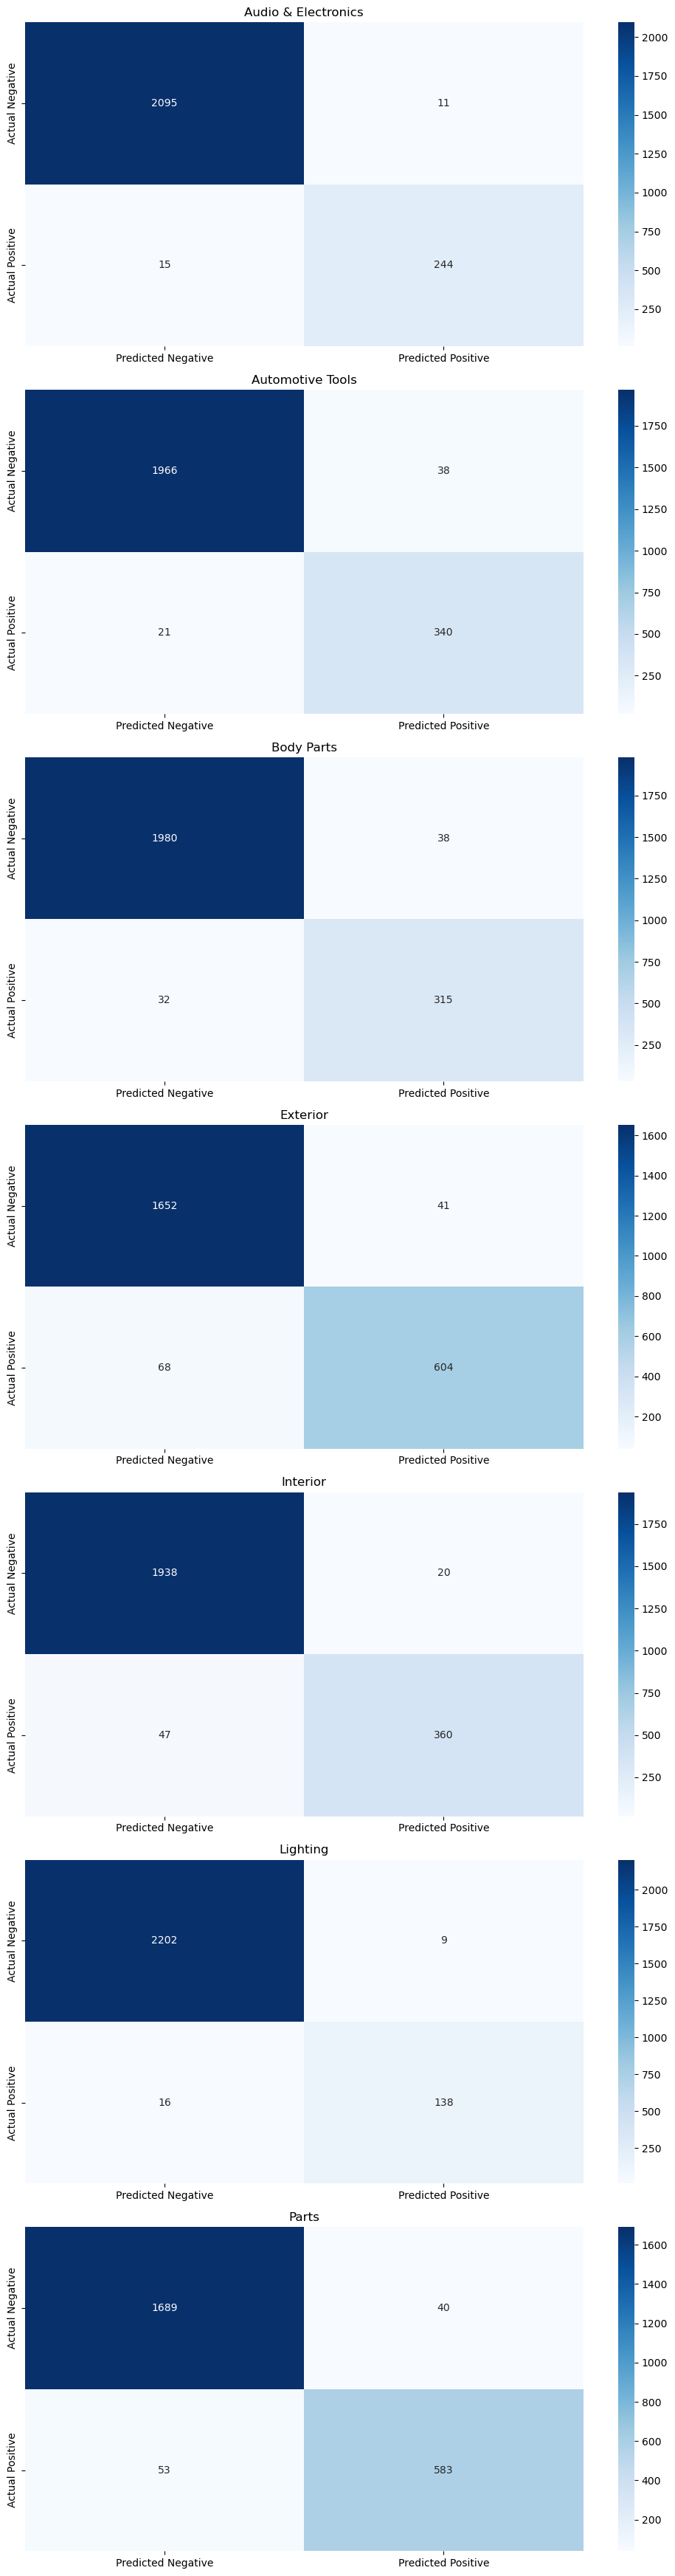

In [34]:
fig, axes = plt.subplots(nrows=len(labels), figsize=(10, 5 * len(labels)))

for i, df in enumerate(dfs):
    ax = axes[i] if len(labels) > 1 else axes
    sns.heatmap(df.iloc[:, :2], annot=True, fmt="d", cmap='Blues', ax=ax)
    ax.set_title(df['Label'].iloc[0])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


In [35]:
precisions = []
recalls = []
f1_scores = []
accuracies = []

for matrix in confusion_matrices:
    tp = matrix[1][1]  # True Positives
    fn = matrix[1][0]  # False Negatives
    fp = matrix[0][1]  # False Positives
    tn = matrix[0][0]  # True Negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

metrics_df = pd.DataFrame({
    'Label': labels,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})


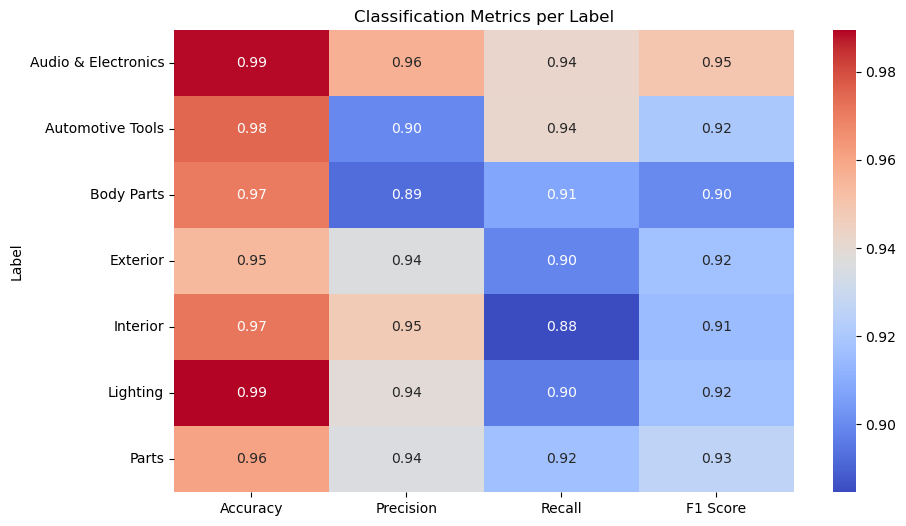

In [36]:
# Heatmap of the metrics
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df.set_index('Label'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Classification Metrics per Label')
plt.show()

### Macro Level Performance

In [39]:
total_TP = 0
total_FP = 0
total_FN = 0
total_TN = 0

# Extract the values and calculate the total number of true positives, false positives, etc.
for matrix in confusion_matrices:
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    
    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

# Calculate overall metrics
overall_accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)
overall_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) else 0
overall_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) else 0
overall_f1_score = (2 * overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) else 0

overall_metrics = {
    'Overall Accuracy': overall_accuracy,
    'Overall Precision': overall_precision,
    'Overall Recall': overall_recall,
    'Overall F1 Score': overall_f1_score
}

overall_metrics

{'Overall Accuracy': 0.9728782845061915,
 'Overall Precision': 0.9856403527953933,
 'Overall Recall': 0.9817046609554233,
 'Overall F1 Score': 0.9836685701815008}

## AWS Comprehend Inference

In [2]:
comprehend_client = boto3.client(service_name='comprehend') 

In [3]:
endpointarn = 'Your_Endpoint_Arn'

In [4]:
product = 'ACANII - For 2006-2014 Honda Ridgeline Headlights Headlamps Replacement 06-14 Driver + Passenger Side'

In [21]:
result = comprehend_client.classify_document(Text=product, EndpointArn=endpointarn)


In [22]:
classes = result['Labels']

for n in classes:
    print(n['Name'], n['Score'])

Lighting 0.9998512268066406
Body Parts 0.9984129667282104
Exterior 0.9973132014274597


In [23]:
product = "Power Stop CRK5377 Coated Brake Rotor & Ceramic Brake Pads- front"

In [24]:
result = comprehend_client.classify_document(Text=product, EndpointArn=endpointarn)
classes = result['Labels']

for n in classes:
    print(n['Name'], n['Score'])

Parts 0.9996479749679565
Body Parts 0.0006331477779895067
Exterior 0.0002936033997684717
